# First try to expand BAX algo functionality

Trying out user defined functions. NB: using main Xopt BAX hooks, need some discussion re: pathwise rewrite.

Based off of https://github.com/xopt-org/Xopt/blob/main/docs/examples/single_objective_bayes_opt/bax_tutorial.ipynb

In [1]:
import torch

from xopt import Xopt
from xopt.vocs import VOCS
from xopt.generators.bayesian.bax_generator import BaxGenerator
from xopt.generators.bayesian.bax.algorithms import GridOptimize
from xopt.evaluator import Evaluator
from xopt.generators.bayesian.bax.visualize import visualize_virtual_objective

import numpy as np
import random

import os
import math
import matplotlib.pyplot as plt

# Ignore all warnings
import warnings

warnings.filterwarnings("ignore")


os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

# random seeds for reproducibility
rand_seed = 2

torch.manual_seed(rand_seed)
np.random.seed(rand_seed)  # only affects initial random observations through Xopt
random.seed(rand_seed)


/sdf/group/mli/sgaz/anaconda3/envs/xopt/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# define variables and function objectives
vocs = VOCS(
    variables={"x": [0, math.pi]},
    observables=["y1"],
)

In [3]:
# define a test function to optimize
def sin_function(input_dict):
    return {"y1": np.sin(input_dict["x"])}

## New: DiscreteSubsetAlgorithm

To be done: write optimizer appropriately

In [4]:
from bax_algorithms.fn_algo_main_xopt import DiscreteSubsetAlgorithm

Define anything you want in the algo_fn. Need to add some requirements on shapes

In [5]:
def algo_fn(y_vals):
    idxs = torch.where((y_vals > 0.4) & (y_vals < 0.6))
    
    return y_vals[idxs].unsqueeze(-1), idxs

In [6]:
# Prepare BAX algorithm and generator options
# "grid" defines domain of the problem
algorithm = DiscreteSubsetAlgorithm(algo_fn=algo_fn, observable_names_ordered=['y1'], 
                                    grid=torch.linspace(0, np.pi, 100)[:, None])

# construct BAX generator
generator = BaxGenerator(vocs=vocs, algorithm=algorithm)
generator.gp_constructor.use_low_noise_prior = True

In [7]:
# construct evaluator
evaluator = Evaluator(function=sin_function)

# construct Xopt optimizer
X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

In [8]:
# evaluate initial points
X.random_evaluate(3)

# inspect the gathered data
X.data

,x,y1,xopt_runtime,xopt_error
0,1.771874,0.979852,0.000017,False
1,3.060143,0.081360,0.000003,False
2,1.414777,0.987854,0.000002,False


In [9]:
def plot_bax(X):
    # get the Gaussian process model from the generator
    model = X.generator.train_model()

    # get acquisition function from generator
    acq = X.generator.get_acquisition(model)

    # calculate model posterior and acquisition function at each test point
    # NOTE: need to add a dimension to the input tensor for evaluating the
    # posterior and another for the acquisition function, see
    # https://botorch.org/docs/batching for details
    # NOTE: we use the `torch.no_grad()` environment to speed up computation by
    # skipping calculations for backpropagation
    with torch.no_grad():
        posterior = model.posterior(test_x.unsqueeze(1))
        acq_val = acq(test_x.reshape(-1, 1, 1))

    # get mean function and confidence regions
    mean = posterior.mean
    L, u = posterior.mvn.confidence_region()

    # plot model and acquisition function
    fig, ax = plt.subplots(3, 1, sharex="all")
    fig.set_size_inches(8, 6)

    # plot model posterior
    ax[0].plot(test_x, mean, label="Posterior mean")
    ax[0].fill_between(test_x, L, u, alpha=0.25, label="Posterior confidence region")

    # add data to model plot
    ax[0].plot(X.data["x"], X.data["y1"], "C1o", label="Training data")

    # plot true function
    true_f = sin_function({"x": test_x})["y1"]
    ax[0].plot(test_x, true_f, "--", label="Ground truth")

    # plot the function samples and their optima found by BAX
    test_points = X.generator.algorithm_results["test_points"]
    posterior_samples = X.generator.algorithm_results["posterior_samples"]
    execution_paths = X.generator.algorithm_results["execution_paths"]

    label1 = "Function Samples"
    label2 = "Sample Optima"
    for i in range(X.generator.algorithm.n_samples):
        (samples,) = ax[1].plot(
            test_points, posterior_samples[i], c="C0", alpha=0.3, label=label1
        )
        ax[1].scatter(
            *execution_paths[i], c="r", marker="x", s=80, label=label2, zorder=10
        )
        label1 = None
        label2 = None

    # plot acquisition function
    ax[2].plot(test_x, acq_val.flatten())

    ax[0].set_ylabel("y1")
    ax[1].set_ylabel("y1")
    ax[2].set_ylabel(r"$\alpha(x)$")
    ax[2].set_xlabel("x")

    return fig, ax

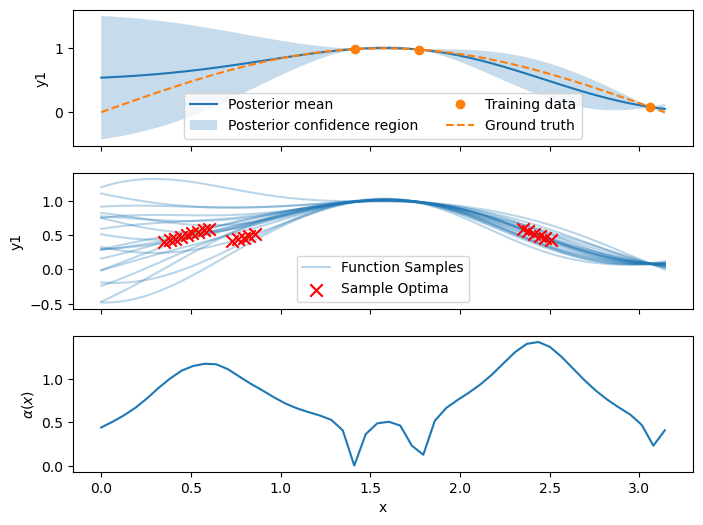

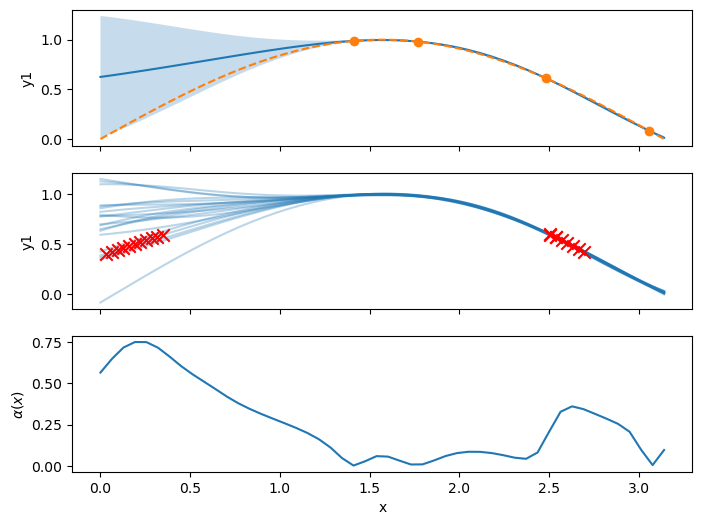

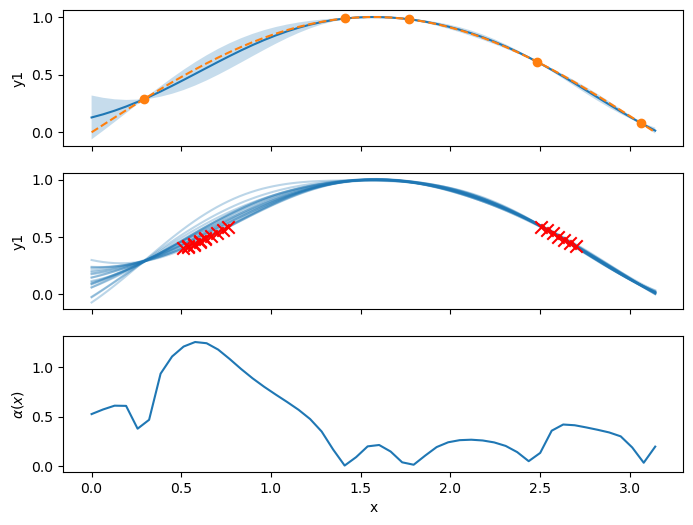

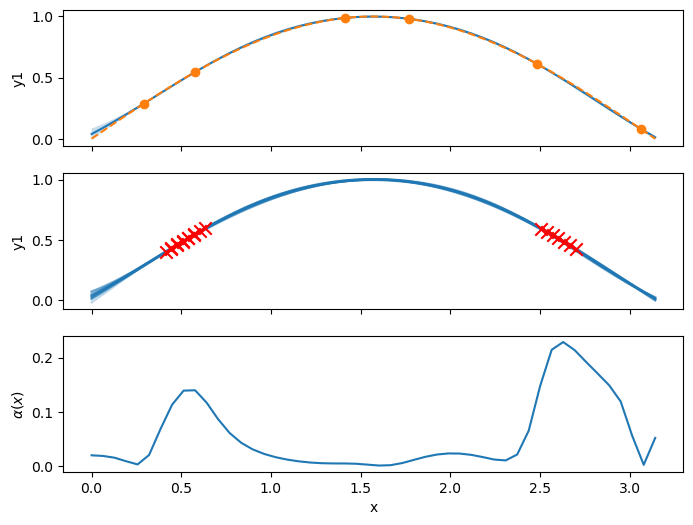

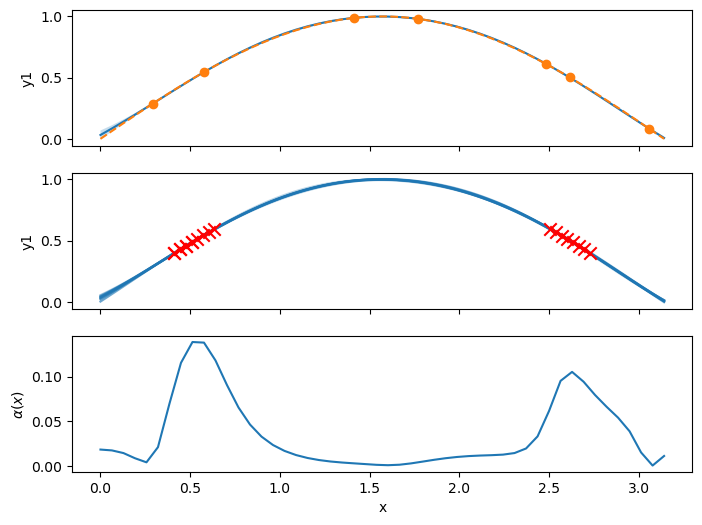

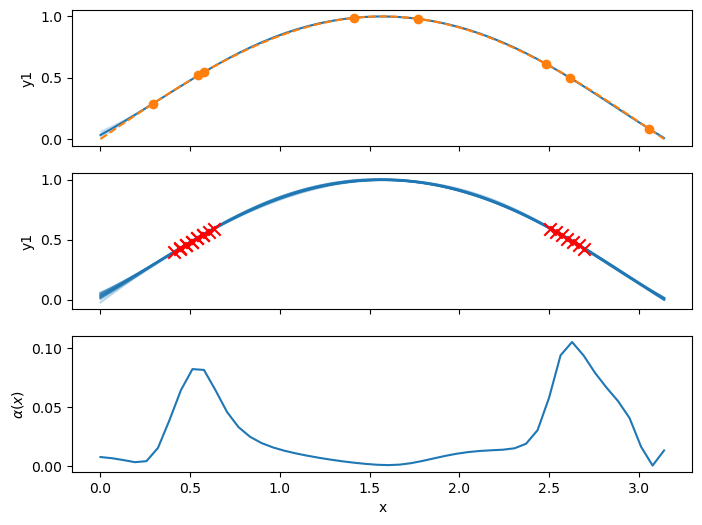

In [10]:
n_steps = 6

# test points for plotting
test_x = torch.linspace(*X.vocs.bounds.flatten(), 50).double()

for i in range(n_steps):
    # plot model and bax information
    fig, ax = plot_bax(X)

    if i == 0:
        ax[0].legend(ncols=2)
        ax[1].legend()
    plt.show()

    # do the optimization step
    X.step()